In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

from google.colab import drive
drive.mount('/content/drive')
drive_dir = '/content/drive/My Drive/Project_3/'

Mounted at /content/drive


In [ ]:
df = pd.read_csv(drive_dir + 'data/promotion_train_data.csv')

\(2\) How much does education matter in promotions?
- What percentage of Bachelor’s Master’s, other get promoted?
- Does education matter more for older \(>40\) or younger \(<40\)
- Masters vs. bachelor’s vs other looking at average training scores and rating
- Look at what education level is most prevalent in each department
- Split up everything by gender as well

Data engineering

#Cleaning Data

In [ ]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [ ]:
df = df.drop('employee_id',axis = 1)

In [ ]:
for col in df.columns:
  percent = 100 * df[col].isna().sum() / df.shape[0]
  percent = round(percent,2)
  print(f'{col}: {df[col].isna().sum()} ({percent}%) missing values')

department: 0 (0.0%) missing values
region: 0 (0.0%) missing values
education: 2409 (4.4%) missing values
gender: 0 (0.0%) missing values
recruitment_channel: 0 (0.0%) missing values
no_of_trainings: 0 (0.0%) missing values
age: 0 (0.0%) missing values
previous_year_rating: 4124 (7.52%) missing values
length_of_service: 0 (0.0%) missing values
KPIs_met >80%: 0 (0.0%) missing values
awards_won?: 0 (0.0%) missing values
avg_training_score: 0 (0.0%) missing values
is_promoted: 0 (0.0%) missing values


In [ ]:
df['education'].unique()

array(["Master's & above", "Bachelor's", nan, 'Below Secondary'],
      dtype=object)

In [ ]:
#Replacing NaN instead of dropping b/c I want to keep those rows
df['education'] = df.education.fillna('Unknown')

In [ ]:
df['previous_year_rating'].unique()

array([ 5.,  3.,  1.,  4., nan,  2.])

In [ ]:
#Ratings are 1-5, so 0 will mean employee was not here last year
df['previous_year_rating'] = df.previous_year_rating.fillna(0)

In [ ]:
df.dtypes

department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
dtype: object

In [ ]:
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [ ]:
df['starting_age'] = df['age']-df['length_of_service']
df['total_training_score'] = df['no_of_trainings']*df['avg_training_score']
df = df.rename(columns={'KPIs_met >80%': 'KPIs_met>80%'})
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,is_promoted,starting_age,total_training_score
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,27,49
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,26,60
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,27,50
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,29,100
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,43,73


In [ ]:
df['previous_year_rating_norm'] = (df['previous_year_rating']-df['previous_year_rating'].min())/(df['previous_year_rating'].max()-df['previous_year_rating'].min())
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,is_promoted,starting_age,total_training_score,previous_year_rating_norm
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,27,49,1.0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,26,60,1.0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,27,50,0.6
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,29,100,0.2
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,43,73,0.6


#Cleaning Data 2

In [ ]:
df.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,is_promoted,starting_age,total_training_score,previous_year_rating_norm
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,27,49,1.0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,26,60,1.0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,27,50,0.6
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,29,100,0.2
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,43,73,0.6


In [ ]:
#based off of percentages of promotion. Lowered older than 40 with 0 rating bc only 11 people
def age_rating(row):
  if row['age'] <= 40 and row['previous_year_rating'] == 0:
    return 10
  elif row['age'] <= 40 and row['previous_year_rating'] == 1:
    return 2
  elif row['age'] <= 40 and row['previous_year_rating'] == 2:
    return 4
  elif row['age'] <= 40 and row['previous_year_rating'] == 3:
    return 7
  elif row['age'] <= 40 and row['previous_year_rating'] == 4:
    return 9
  elif row['age'] <= 40 and row['previous_year_rating'] == 5:
    return 12
  elif row['age'] > 40 and row['previous_year_rating'] == 0:
    return 6
  elif row['age'] > 40 and row['previous_year_rating'] == 1:
    return 1
  elif row['age'] > 40 and row['previous_year_rating'] == 2:
    return 3
  elif row['age'] > 40 and row['previous_year_rating'] == 3:
    return 5
  elif row['age'] > 40 and row['previous_year_rating'] == 4:
    return 8
  else:
    return 11


In [ ]:
def age_KPI(row):
  if row['age'] <= 45 and row['KPIs_met>80%'] == 0:
    return 2
  elif row['age'] <= 45 and row['KPIs_met>80%'] == 1:
    return 4
  elif row['age'] > 45 and row['KPIs_met>80%'] == 0:
    return 3
  else:
    return 1

In [ ]:
df_encoded = df.copy()

In [ ]:
df_encoded['age_rating'] = df_encoded.apply(age_rating, axis=1)

In [ ]:
df_encoded['age_KPI'] = df_encoded.apply(age_KPI, axis=1)

In [ ]:
df_encoded.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met>80%,awards_won?,avg_training_score,is_promoted,starting_age,total_training_score,previous_year_rating_norm,age_rating,age_KPI
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0,27,49,1.0,12,4
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0,26,60,1.0,12,2
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0,27,50,0.6,7,2
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0,29,100,0.2,2,2
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0,43,73,0.6,5,2


In [ ]:
feat_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 
             'previous_year_rating', 'length_of_service', 'KPIs_met>80%', 'awards_won?', 'avg_training_score', 
             'starting_age', 'total_training_score', 'previous_year_rating_norm', 'age_rating', 'age_KPI']

In [ ]:
#Percent of people to get promoted in each category
def promo_by_group(col):
  for i,group in df_encoded.groupby(col):
    total = group.shape[0]
    promoted = group[group['is_promoted'] == 1].shape[0]
    percent = 100*promoted/total
    print(f"{i}: promoted {percent:.2f}% of the time. ({promoted} out of {total})")

In [ ]:
category = feat_cols

for col in category:
  print(col.upper(), ':')
  print(promo_by_group(col))
  print("="*100)

DEPARTMENT :
Analytics: promoted 9.57% of the time. (512 out of 5352)
Finance: promoted 8.12% of the time. (206 out of 2536)
HR: promoted 5.62% of the time. (136 out of 2418)
Legal: promoted 5.10% of the time. (53 out of 1039)
Operations: promoted 9.01% of the time. (1023 out of 11348)
Procurement: promoted 9.64% of the time. (688 out of 7138)
R&D: promoted 6.91% of the time. (69 out of 999)
Sales & Marketing: promoted 7.20% of the time. (1213 out of 16840)
Technology: promoted 10.76% of the time. (768 out of 7138)
None
REGION :
region_1: promoted 9.51% of the time. (58 out of 610)
region_10: promoted 7.87% of the time. (51 out of 648)
region_11: promoted 5.63% of the time. (74 out of 1315)
region_12: promoted 6.60% of the time. (33 out of 500)
region_13: promoted 8.69% of the time. (230 out of 2648)
region_14: promoted 7.50% of the time. (62 out of 827)
region_15: promoted 7.91% of the time. (222 out of 2808)
region_16: promoted 6.96% of the time. (102 out of 1465)
region_17: promoted

Copying everything over from Stephanie's notebook

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
for c in df_encoded.columns:
  if c != 'default':  
    if df_encoded[c].dtype == object:  #If it is a string, then encode it. 
        try:  
            le = LabelEncoder()           
            le.fit(df_encoded[c].unique())    
            df_encoded[c] = le.transform(df_encoded[c])  
        except Exception as e:         
            print(c)         
            print(e)

In [ ]:
female_df = df_encoded[df_encoded['gender']==0]
male_df = df_encoded[df_encoded['gender']==1]

female_train_df, female_test_df = train_test_split(female_df, test_size=0.3, random_state=0, stratify=female_df['is_promoted'])
male_train_df, male_test_df = train_test_split(male_df, test_size=0.3, random_state=0, stratify=male_df['is_promoted'])

In [ ]:
feat_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 
             'previous_year_rating', 'length_of_service', 'KPIs_met>80%', 'awards_won?', 'avg_training_score', 
             'starting_age', 'total_training_score', 'previous_year_rating_norm', 'age_rating', 'age_KPI']
target_col = 'is_promoted'

female_X_train = female_train_df[feat_cols]
female_y_train = female_train_df[target_col]

male_X_train = male_train_df[feat_cols]
male_y_train = male_train_df[target_col]

female_X_test = female_test_df[feat_cols]
female_y_test = female_test_df[target_col]

male_X_test = male_test_df[feat_cols]
male_y_test = male_test_df[target_col]

In [ ]:
female_train_yes_df = female_train_df[female_train_df['is_promoted'] == 1]
female_train_yes_df = female_train_yes_df.sample(10391, replace=True)

female_train_no_df = female_train_df[female_train_df['is_promoted'] == 0]

# And now stick both DataFrames together to make a new oversampled training set
female_train_over_df = pd.concat([female_train_no_df, female_train_yes_df])

In [ ]:
male_train_yes_df = male_train_df[male_train_df['is_promoted'] == 1]
male_train_yes_df = male_train_yes_df.sample(24706, replace=True)

male_train_no_df = male_train_df[male_train_df['is_promoted'] == 0]

# And now stick both DataFrames together to make a new oversampled training set
male_train_over_df = pd.concat([male_train_no_df, male_train_yes_df])

In [ ]:
feat_cols = ['department', 'region', 'education', 'gender', 'recruitment_channel', 'no_of_trainings', 'age', 
             'previous_year_rating', 'length_of_service', 'KPIs_met>80%', 'awards_won?', 'avg_training_score', 
             'starting_age', 'total_training_score', 'previous_year_rating_norm', 'age_rating', 'age_KPI']
target_col = 'is_promoted'

female_X_train_over = female_train_over_df[feat_cols]
female_y_train_over = female_train_over_df[target_col]

In [ ]:
# Get only the customers who did not get promoted
female_train_no_df = female_train_df[female_train_df['is_promoted'] == 0]
# Then select of them to match the "1" is_promoted employees
female_train_no_df = female_train_no_df.sample(1027)

# Also grab the promoted employees
female_train_yes_df = female_train_df[female_train_df['is_promoted'] == 1]

# And now stick both DataFrames together to make a new undersampled training set
female_train_under_df = pd.concat([female_train_no_df, female_train_yes_df])

In [ ]:
# Get only the customers who did not get promoted
male_train_no_df = male_train_df[male_train_df['is_promoted'] == 0]
# Then select of them to match the "1" is_promoted employees
male_train_no_df = male_train_no_df.sample(2241)

# Also grab the promoted employees
male_train_yes_df = male_train_df[male_train_df['is_promoted'] == 1]

# And now stick both DataFrames together to make a new undersampled training set
male_train_under_df = pd.concat([male_train_no_df, male_train_yes_df])

#Seaborn plots 2

##Male Oversample

In [ ]:
#Percent of people to get promoted in each category
def promo_by_group(col):
  for i,group in male_train_over_df.groupby(col):
    total = group.shape[0]
    promoted = group[group['is_promoted'] == 1].shape[0]
    percent = 100*promoted/total
    print(f"{i}: promoted {percent:.2f}% of the time. ({promoted} out of {total})")

In [ ]:
category = feat_cols

for col in category:
  print(col.upper(), ':')
  print(promo_by_group(col))
  print("="*100)

DEPARTMENT :
0: promoted 54.21% of the time. (3588 out of 6619)
1: promoted 47.92% of the time. (1129 out of 2356)
2: promoted 40.39% of the time. (637 out of 1577)
3: promoted 35.96% of the time. (333 out of 926)
4: promoted 51.76% of the time. (4567 out of 8824)
5: promoted 47.65% of the time. (2264 out of 4751)
6: promoted 43.17% of the time. (477 out of 1105)
7: promoted 47.37% of the time. (7963 out of 16811)
8: promoted 58.17% of the time. (3748 out of 6443)
None
REGION :
0: promoted 59.22% of the time. (408 out of 689)
1: promoted 44.27% of the time. (259 out of 585)
2: promoted 34.76% of the time. (366 out of 1053)
3: promoted 33.04% of the time. (113 out of 342)
4: promoted 52.27% of the time. (1267 out of 2424)
5: promoted 44.38% of the time. (316 out of 712)
6: promoted 44.75% of the time. (1163 out of 2599)
7: promoted 47.78% of the time. (549 out of 1149)
8: promoted 61.16% of the time. (381 out of 623)
9: promoted 0.00% of the time. (0 out of 17)
10: promoted 42.07% of th

In [ ]:
import seaborn as sns

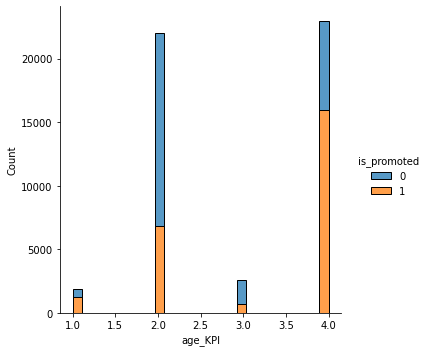

In [ ]:
sns.displot(data= male_train_over_df, x= 'age_KPI', hue= 'is_promoted', multiple= 'stack')

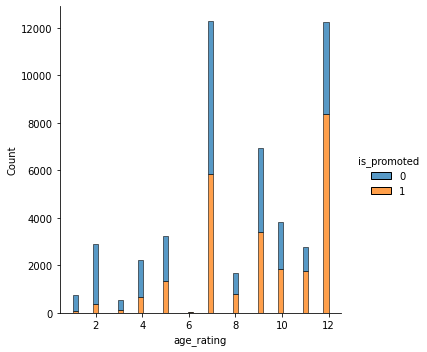

In [ ]:
sns.displot(data= male_train_over_df, x= 'age_rating', hue= 'is_promoted', multiple= 'stack')

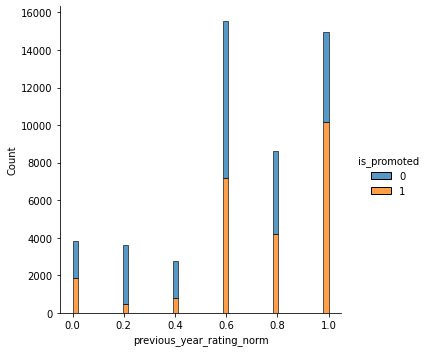

In [ ]:
sns.displot(data= male_train_over_df, x= 'previous_year_rating_norm', hue= 'is_promoted', multiple= 'stack')

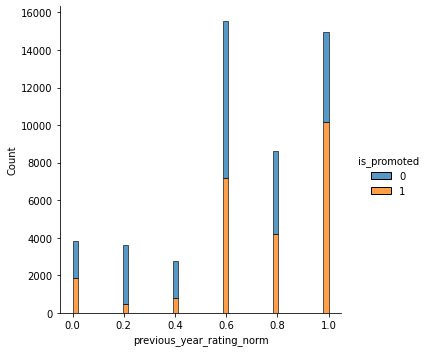

In [ ]:
sns.displot(data= male_train_over_df, x= 'previous_year_rating_norm', hue= 'is_promoted', multiple= 'stack')

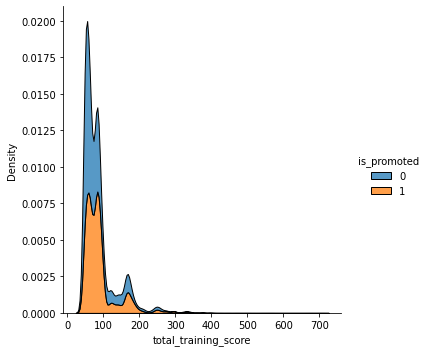

In [ ]:
sns.displot(data= male_train_over_df, x= 'total_training_score', hue= 'is_promoted', multiple= 'stack', kind='kde')

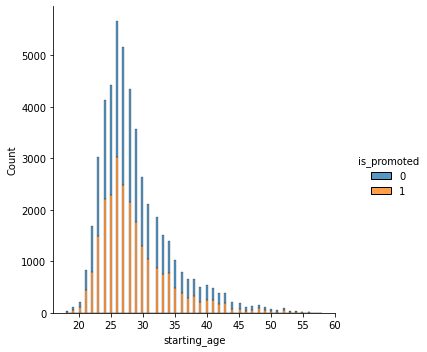

In [ ]:
sns.displot(data= male_train_over_df, x= 'starting_age', hue= 'is_promoted', multiple= 'stack')

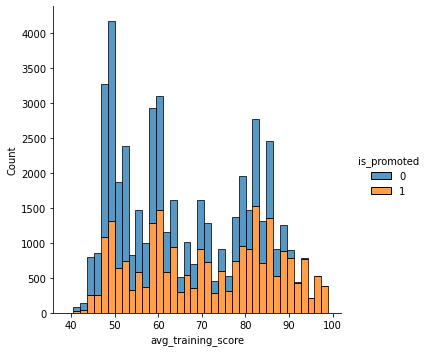

In [ ]:
sns.displot(data= male_train_over_df, x= 'avg_training_score', hue= 'is_promoted', multiple= 'stack')

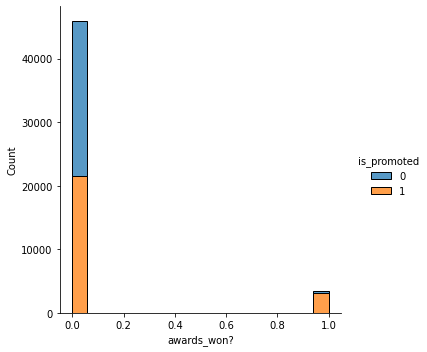

In [ ]:
sns.displot(data= male_train_over_df, x= 'awards_won?', hue= 'is_promoted', multiple= 'stack')

In [ ]:
sns.displot(data= male_train_over_df, x= 'length_of_service', hue= 'is_promoted', multiple= 'stack')

In [ ]:
sns.displot(data= male_train_over_df, x= 'previous_year_rating', hue= 'is_promoted', multiple= 'stack')

In [ ]:
sns.displot(data= male_train_over_df, x= 'no_of_trainings', hue= 'is_promoted', multiple= 'stack')

In [ ]:
sns.displot(data= male_train_over_df, x= 'recruitment_channel', hue= 'is_promoted', multiple= 'stack')

In [ ]:
sns.displot(data= male_train_over_df, x= 'education', hue= 'is_promoted', multiple= 'stack')

In [ ]:
sns.displot(data= male_train_over_df, x= 'age', col= 'is_promoted', kind= 'kde')

In [ ]:
sns.displot(data= male_train_over_df, x= 'region', hue='is_promoted', bins=male_train_over_df['region'].nunique(), stat='count', multiple='stack')

In [ ]:
sns.displot(data= male_train_over_df, x= 'department', hue= 'is_promoted', multiple='stack')

In [ ]:
sns.displot(data= male_train_over_df, x= 'KPIs_met>80%', hue= 'is_promoted', bins=2, multiple='stack')

##Female Oversample

In [ ]:
#Percent of people to get promoted in each category
def promo_by_group(col):
  for i,group in female_train_over_df.groupby(col):
    total = group.shape[0]
    promoted = group[group['is_promoted'] == 1].shape[0]
    percent = 100*promoted/total
    print(f"{i}: promoted {percent:.2f}% of the time. ({promoted} out of {total})")

In [ ]:
category = feat_cols

for col in category:
  print(col.upper(), ':')
  print(promo_by_group(col))
  print("="*100)